In [1]:
import imageio
import scipy.ndimage as snd
from skimage import feature
from skimage.draw import circle

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
%matplotlib notebook

# Nummerical library
import numpy as np

# System library e.g. for opening files in a library
import os

The second order derivative of a Gaussian is:
$$\frac{d^2}{dx^2}g = \frac{d^2}{dx^2}\frac{1}{\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} = 
\frac{d}{dx}\frac{-x}{t\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} = 
\frac{-1}{t\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} + \frac{x^2}{t^2\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} =
\left(\frac{x^2}{t^2}-\frac{1}{t}\right)\frac{1}{\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} = \left(\frac{x^2}{t^2}-\frac{1}{t}\right)\cdot g$$
This way of writing it is simpler than the default output of Maple.

## The following is very important
We want to calculate the Laplacian of the Gaussian
$$\nabla^2L = L_{xx}+L_{yy}$$
where $L_{xx}$ is defined by
$$L_{xx}=\frac{d^2}{dx^2}L=\frac{d^2}{dx^2}I*g(x,y)=\frac{d^2}{dx^2}I*g(x)*g(y)=g(y)*I*\frac{d^2g(x)}{dx^2}$$
This means $L_{xx}$ is calculated by colvoling the image with the 2nd derivative of the gaussian along the x-axis and a regular gaussian along the y-axis.

In [2]:
def gaussian(t=3, s=5):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = 1.0/np.sqrt(t*2.0*np.pi)*np.exp(-(x**2.0)/(2.0*t))
    return filt

def fst_deriv_gaussian(t=3, s=5):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = (-x/t)*gaussian(t, s=s)
    return filt

def scd_deriv_gaussian(t=3, s=5):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = ((x**2.0)/(t**2.0) - 1/t)*gaussian(t, s=s)
    return filt

The size of $t=\sigma^2$ is selected such that it matches the relationship shown in the notes $$r=\sqrt{2\pi}\Leftrightarrow t=r^2/2$$

In [3]:
t_val = 25**2/2
scd_gauss = scd_deriv_gaussian(t_val)
gauss = gaussian(t_val)

<IPython.core.display.Javascript object>


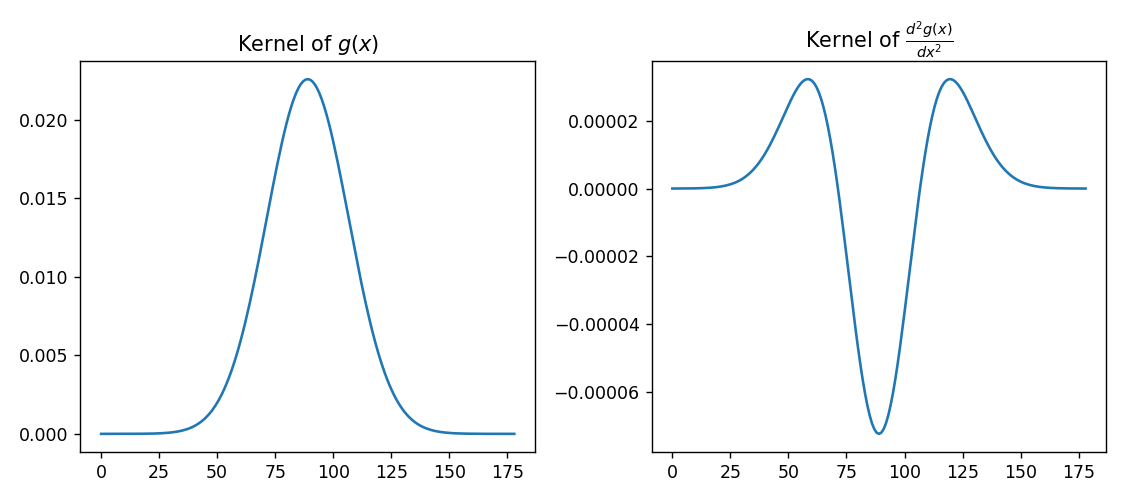

In [4]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(9,4))

im1 = f1_axes[0].plot(gauss)
f1_axes[0].set_title('Kernel of $g(x)$')
im2 = f1_axes[1].plot(scd_gauss)
f1_axes[1].set_title('Kernel of $\\frac{d^2g(x)}{dx^2}$')

fig1.show()
fig1.tight_layout()

Note that performing two 1d convolutions is computationally faster than performing one 2d covolution.

In [5]:
im = imageio.imread('EX_2_data/test_blob_uniform.png.').astype('float')

filt_Lxx = np.outer(scd_gauss, np.transpose(gauss))
# Very slow
%time Lxx = snd.filters.convolve(im, filt_Lxx)

# Much faster
%time Lxx = snd.filters.convolve1d(im, scd_gauss, axis=1)
%time Lxx = snd.filters.convolve1d(Lxx, np.transpose(gauss), axis=0)

Lyy = snd.filters.convolve1d(im, np.transpose(scd_gauss), axis=0)
Lyy = snd.filters.convolve1d(Lyy, gauss, axis=1)

L = Lxx + Lyy

Wall time: 23.3 s
Wall time: 22.9 ms
Wall time: 22 ms


<IPython.core.display.Javascript object>


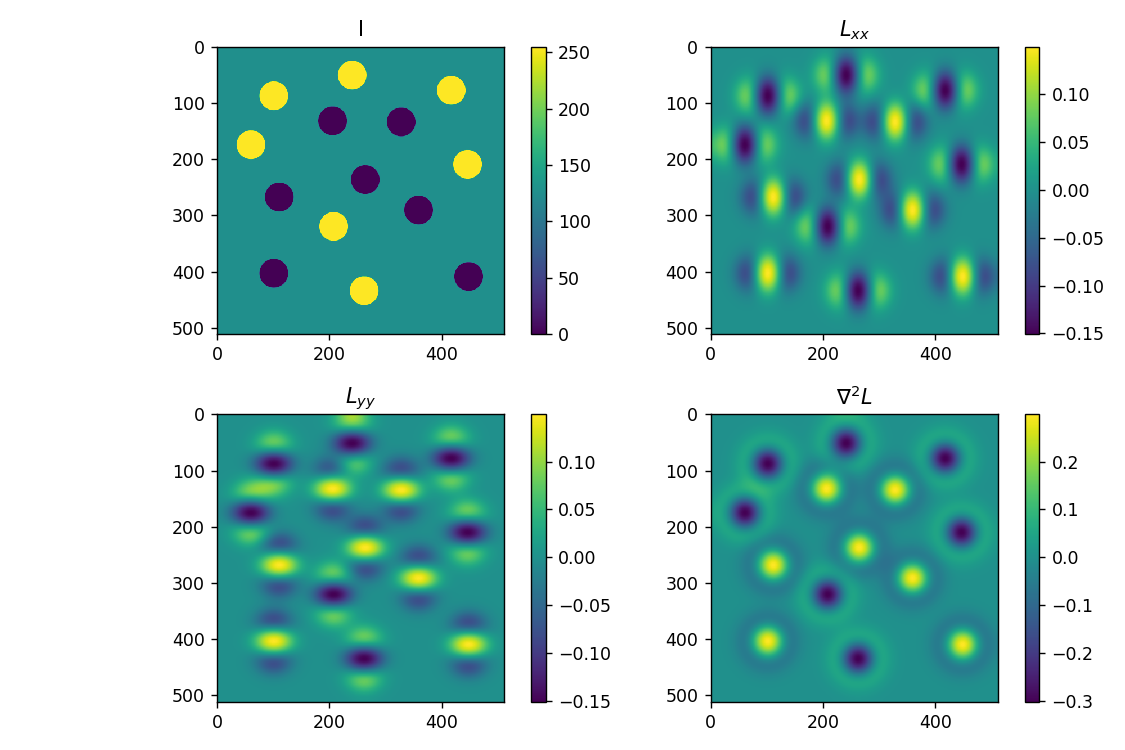

In [6]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=False, figsize=(9,6))

im1 = f1_axes[0,0].imshow(im, cmap='viridis') #[378:430, 75:127]
f1_axes[0,0].set_title('I')
fig1.colorbar(im1, ax=f1_axes[0,0], fraction=0.046)
im2 = f1_axes[0,1].imshow(Lxx, cmap='viridis')
f1_axes[0,1].set_title('$L_{xx}$')
fig1.colorbar(im2, ax=f1_axes[0,1], fraction=0.046)
im3 = f1_axes[1,0].imshow(Lyy, cmap='viridis')
f1_axes[1,0].set_title('$L_{yy}$')
fig1.colorbar(im3, ax=f1_axes[1,0], fraction=0.046)
im4 = f1_axes[1,1].imshow(L, cmap='viridis')
f1_axes[1,1].set_title('$\\nabla^2 L$')
fig1.colorbar(im4, ax=f1_axes[1,1], fraction=0.046)

fig1.show()
fig1.tight_layout()

## Detecting the blobs
We can clearly see that $\nabla^2 L$ have a local minima and maxima and the center of the blobs which we want to detect. There are multiple ways of doing this. My method involves comparing each pixels with its neighbours which will find all local extrema. However, from the image of the Laplacian we can see that the edges around the bright and dark centers are also local extrema. These points can be removed by thresholding the Laplacian. You can make your own algorithm or use a predefined one. `skimage.feature.peak_local_max` can find local maxima above a relative threshold.

In [7]:
center_min = feature.peak_local_max(-L, min_distance=1, threshold_rel=0.9)
center_max = feature.peak_local_max(L, min_distance=1, threshold_rel=0.9)

<IPython.core.display.Javascript object>


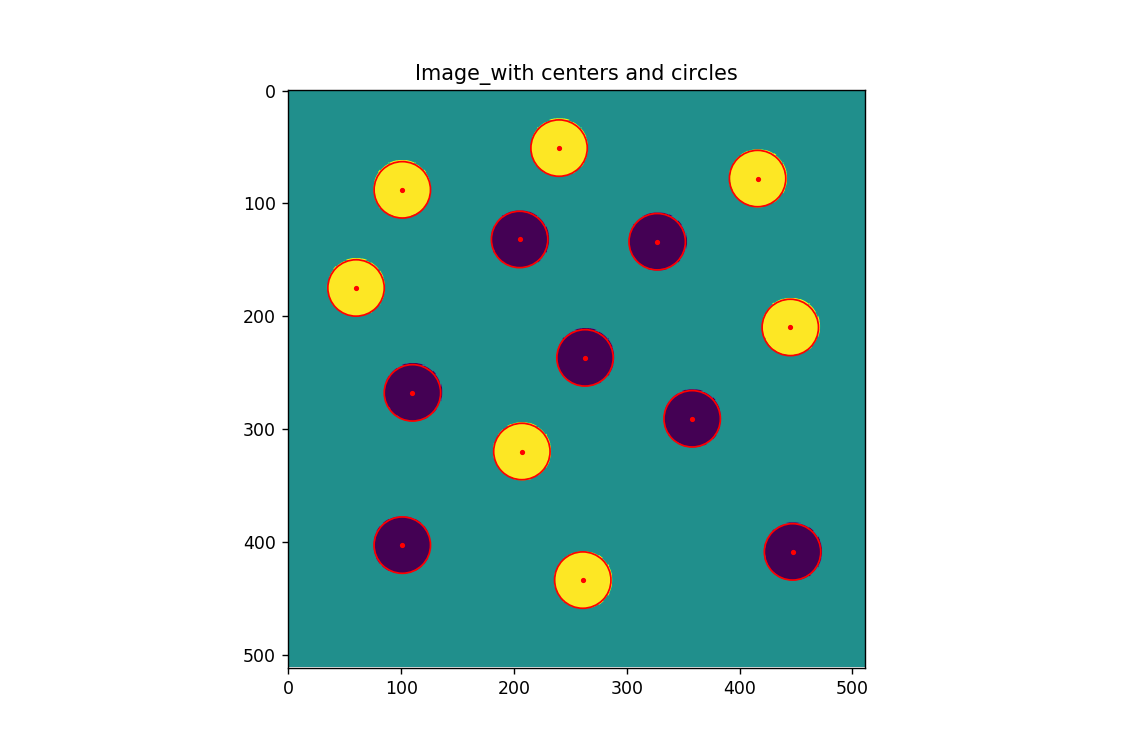

In [8]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(im, cmap='viridis')
ax.set_title('Image_with centers and circles')
ax.scatter(center_min[:,1], center_min[:,0], c='red', s=4)
ax.scatter(center_max[:,1], center_max[:,0], c='red', s=4)
for iCirc in range(len(center_min[:,1])):
    circ = plt.Circle((center_min[iCirc,1], center_min[iCirc,0]), 25, edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
    circ = plt.Circle((center_max[iCirc,1], center_max[iCirc,0]), 25, edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
fig1.show()
fig1.tight_layout()

Finding blobs across scale space requires calculating the scale invariant Laplacian $t\nabla^2L$. A blobs will have the strongest response at the value of $t$ which matches the radius of it.

In [9]:
def scan_scale_space(im, t):
    r, c = im.shape
    L = np.zeros((len(t),r,c))
    
    for iScale in range(len(t)):
        scd_gauss = scd_deriv_gaussian(t[iScale], s=5)
        gauss = gaussian(t[iScale], s=5)

        Lxx = snd.filters.convolve1d(im, scd_gauss, axis=1)
        Lxx = snd.filters.convolve1d(Lxx, np.transpose(gauss), axis=0)

        Lyy = snd.filters.convolve1d(im, np.transpose(scd_gauss), axis=0)
        Lyy = snd.filters.convolve1d(Lyy, gauss, axis=1)

        L[iScale, :, :] = t[iScale]*(Lxx + Lyy)
    return L

In [10]:
min_blob_size = 2
max_blob_size = 45
radius_scan = np.arange(min_blob_size, max_blob_size)

t = radius_scan**2/2
L = scan_scale_space(im, t)

We can examine the effect of $t$ using the following plot where the slider can be moved to see the effect of increasing $t$. The strongest repsonse is seen when the value of $t$ matches a radius of 25 which is what the blobs have.

<IPython.core.display.Javascript object>


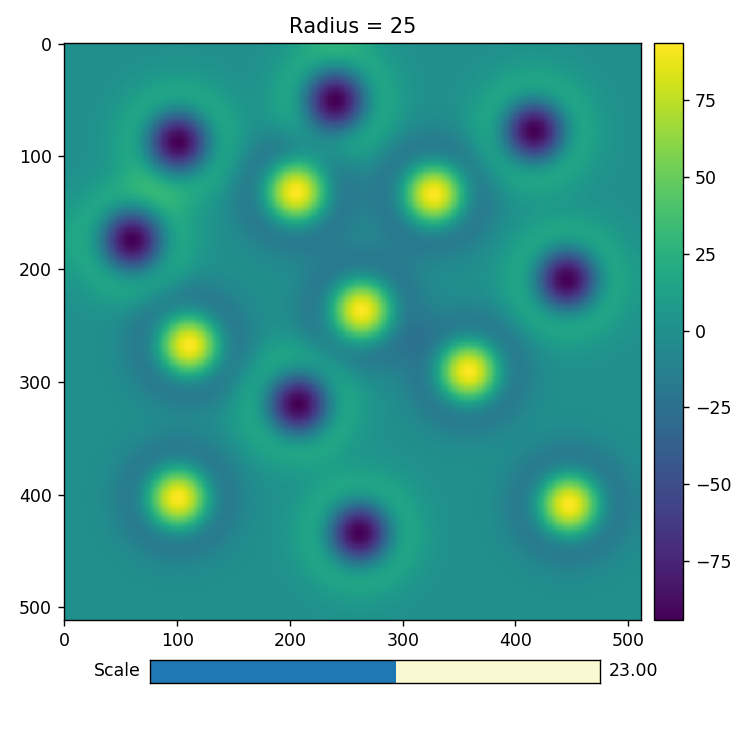

C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [11]:
def get_next_scale(val):
    iScale = int(sscale.val)
    im1.set_data(L[iScale, :, :])
    ax.set_title('Radius = %i' % (radius_scan[iScale]))
#    im1.set_clim(np.nanmin(L[iScale, :, :]), np.nanmax(L[iScale, :, :]))
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im1 = ax.imshow(L[0, :, :], cmap='viridis')
im1.set_clim(np.nanmin(L), np.nanmax(L))
ax.set_title('Radius = %i' % (radius_scan[0]))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cax)

axcolor = 'lightgoldenrodyellow'
ax_scale = plt.axes([0.2, 0.09, 0.6, 0.03], facecolor=axcolor)
sscale = Slider(ax_scale, 'Scale', 0, len(t)-1, valinit=0, valstep=1)

sscale.on_changed(get_next_scale)
plt.tight_layout(rect=[0, 0.11, 1, 1])